In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-03 14:02:52.981019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 14:02:53.652884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

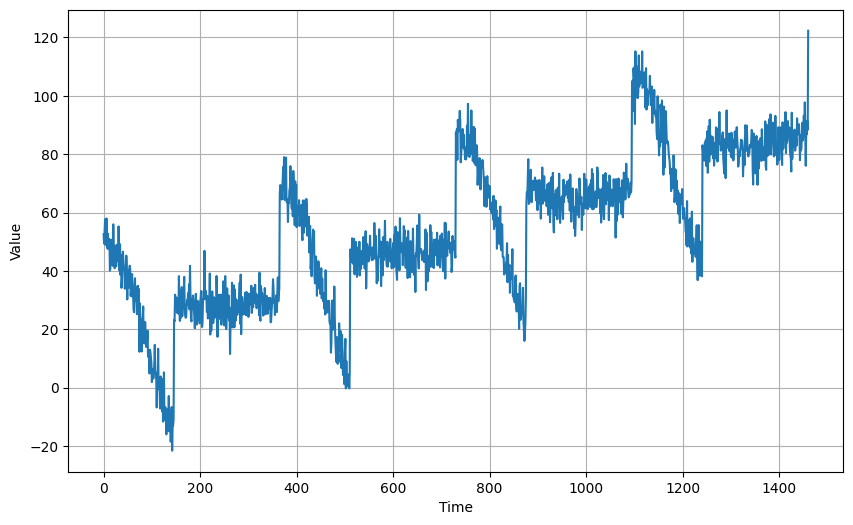

In [4]:
time = np.arange(4*365+1,dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
series+=noise(time,noise_level,seed=42)
plot_series(time,series)

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

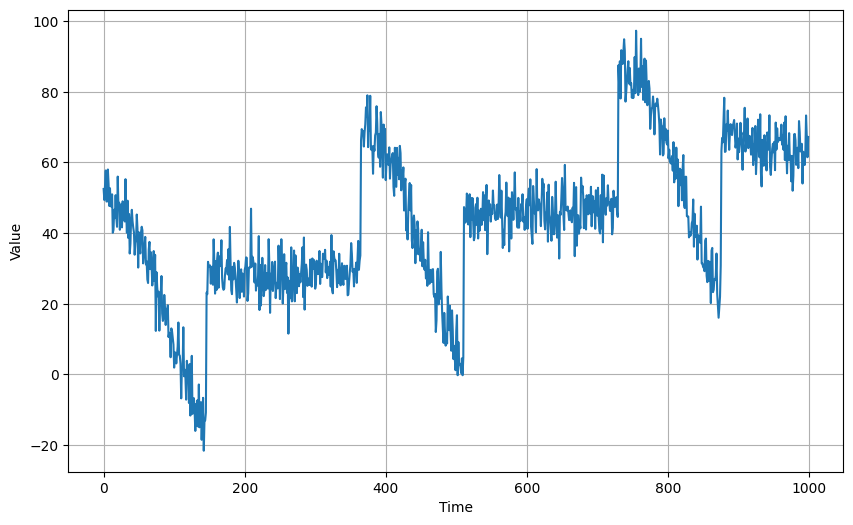

In [6]:
# Plot the train set
plot_series(time_train, x_train)

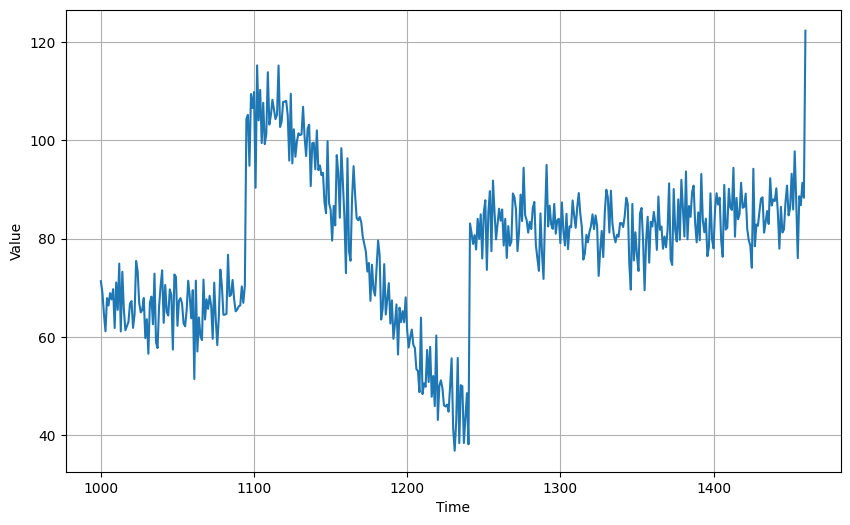

In [7]:
# Plot the validation set
plot_series(time_valid, x_valid)

Preparing Features and Labels

In [8]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [15]:
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [17]:
for windows in dataset.take(1):
    print(f'data type: {type(windows)}')
    print(f'number of elements in the tuple: {len(windows)}')
    print(f'shape of first element: {windows[0].shape}')
    print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


#### Building the model

In [18]:
l0 = tf.keras.layers.Dense(1,input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

print("Layer weights: \n {} \n".format(l0.get_weights()))

model.summary()

Layer weights: 
 [array([[ 0.06076443],
       [ 0.20406228],
       [-0.19088498],
       [-0.00140959],
       [ 0.47662884],
       [-0.01660037],
       [-0.08338609],
       [-0.26765975],
       [ 0.24506831],
       [-0.5118911 ],
       [ 0.13436198],
       [-0.40526205],
       [ 0.35108125],
       [-0.03394377],
       [ 0.50177366],
       [-0.45214763],
       [ 0.41089284],
       [-0.368245  ],
       [ 0.47885805],
       [-0.05638358]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,
                                                            momentum=0.9))

In [21]:
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 231.4786
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 116.2562
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 103.9498
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 100.5055
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 96.3001
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 93.5697
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 92.4588
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 88.0260
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 87.3652
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 86.8825
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 83.7640
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 84.7330
Epoch 13/100
31/31 [=

In [22]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03073671],
       [ 0.00453902],
       [-0.00644955],
       [-0.04612064],
       [ 0.127675  ],
       [-0.02916091],
       [-0.00651335],
       [-0.05783219],
       [ 0.08846239],
       [-0.06958914],
       [ 0.05711273],
       [-0.1085879 ],
       [ 0.0531403 ],
       [-0.00353826],
       [ 0.12128917],
       [-0.07310554],
       [ 0.12581347],
       [ 0.06750077],
       [ 0.38093373],
       [ 0.3880062 ]], dtype=float32), array([0.01449305], dtype=float32)]


In [27]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 30ms/step


model prediction: [[41.307]]


In [28]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 14ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


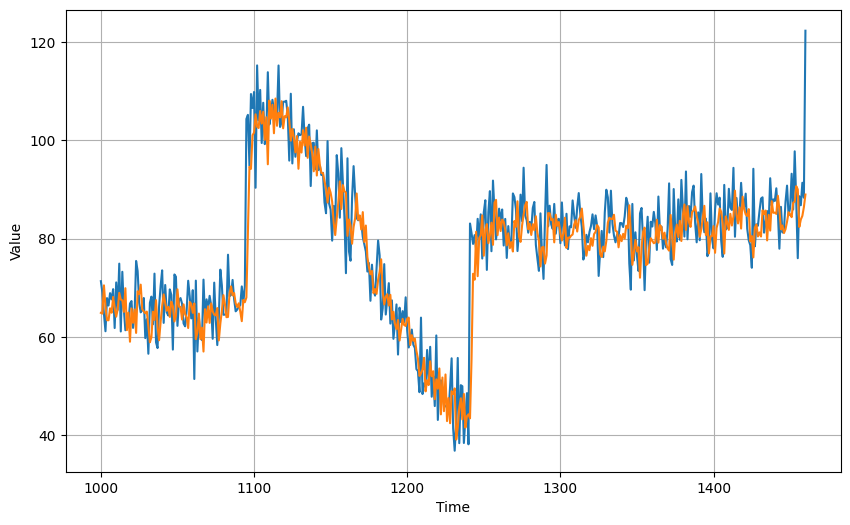

In [29]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [30]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.848324
5.0718875
